In [82]:
import csv, pickle, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
from autosklearn.regression import AutoSklearnRegressor
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from prophet import Prophet

In [83]:
with open('./models/tmp/Stadium_Data_Extended_present_elec_kwh_linear_interpolation', 'rb') as file:
    model_data = pickle.load(file)

print(model_data['y'])

0         15.0
1         15.0
2         15.0
3         15.0
4         15.0
         ...  
29560    153.0
29561    207.0
29562    143.0
29563    202.0
29564    136.0
Name: y, Length: 29565, dtype: float64


In [84]:
with open('./present_elec_kwh.json', 'r') as f:
    data = json.load(f)

# Reshape the 'data' array to a list of floats
print(data['data'])

[191.7207, 153.17255, 206.26294, 158.5806, 198.50697, 153.27017, 177.83241, 174.96281, 194.55023, 146.80211, 198.12485, 160.7924, 204.70633, 145.75797, 209.21501, 146.74716, 199.05115, 161.89531, 193.95996, 149.9395, 187.85753, 159.62474, 202.39708, 149.08394, 184.91928, 175.58661, 195.49158, 153.18379, 191.22719, 150.20235]


Stadium_Data_Extended.csv


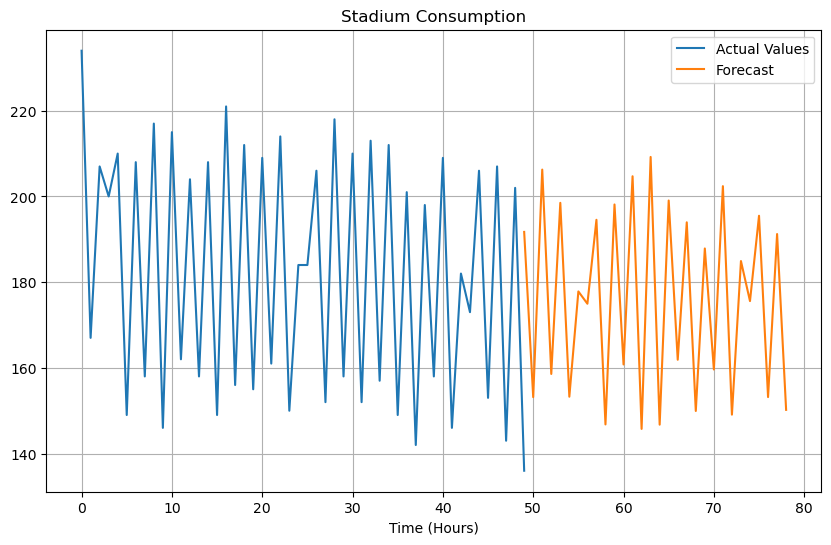

In [85]:
buildings_list = ['Stadium_Data_Extended.csv']

in_path = './clean_data_extended/'

# Training scope
models = {}
model_types = ['xgboost']
preprocessing_methods = ['linear interpolation']

# Settings
min_number_of_days = 365
memory_limit = 102400
save_model_file = False
save_model_plot = True
exclude_column = 'present_co2_tons'

y_columns = ['present_elec_kwh', 'present_htwt_mmbtu', 'present_wtr_usgal', 'present_chll_tonhr', 'present_co2_tons']
add_features = ['temp_c', 'rel_humidity_%', 'surface_pressure_hpa', 'cloud_cover_%', 'direct_radiation_w/m2', 'precipitation_mm', 'wind_speed_ground_km/h', 'wind_dir_ground_deg']

# Hyperparameters
n_features_list = [2]
time_steps = [24]
minutes_per_model = 2
split_rate = 0.8

for model_type in model_types:
    out_path = f'./models/{model_type}/'

    for building in buildings_list:
        df = pd.read_csv(in_path + building)

        # Convert the data into a Pandas dataframe
        df['ts'] = pd.to_datetime(df['ts'])
        df = df.drop_duplicates(subset=['bldgname', 'ts'])
        df = df.sort_values(['bldgname', 'ts'])

        # Group the dataframe by building name and timestamp
        groups = df.groupby('bldgname')
        df = df.set_index('ts')
        header = ['ts'] + y_columns + add_features

        print(building)

        # save plot 
        if save_model_plot == True:
            # plot results
            fig, ax = plt.subplots(figsize=(10, 6))

            new_model_data = model_data['y'][-50:].reset_index(drop=True)
 
            # Plot the actual values
            # Plot the actual values from model_data['y']
            ax.plot(new_model_data, label='Actual Values')

            # Get the length of model_data['y']
            start_index = len(new_model_data) - 1

            # Generate x-axis values for the forecast data based on the start index
            x_values = range(start_index, start_index + len(data['data']))
            # Plot the forecast data starting from the last index of model_data['y']
            ax.plot(x_values, data['data'], label='Forecast')

            # Plot the predictions
            # ax.plot(y_pred, label='Forecasted Values', alpha=0.8)
            # # ax.plot(range(train_len, train_len + len(y_test)), y_pred, label='Predicted Values')

            
            # ax.plot(y_test, label='Predicted Values', alpha=0.75)

            ax.set_title('Stadium Consumption')
            ax.set_xlabel('Time (Hours)')
            # ax.set_ylabel(y.split('_')[-2] + ' (' + y.split('_')[-1] + ')')

            ax.legend()
            plt.grid(True)
            plt.savefig('test' + '.png')
            # plt.close(fig)